<a href="https://colab.research.google.com/github/vkbyba/goit-ds-hw-11/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22GoIT_HW_8_new_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [1]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [5]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [8]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.dense1 = DenseLayer(in_features=num_features, out_features=128)
    # Другий шар, який складається з 256 нейронів
    self.dense2 = DenseLayer(in_features=128, out_features=256)
    # Вихідний шар
    self.out_layer = DenseLayer(in_features=256, out_features=10)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.out_layer(x, activation=1)
    return x

In [10]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    correct_predictions = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [11]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [12]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy() * 100:.2f}%")


Step 100, Loss: 279.22613525390625, Accuracy: 67.58%
Step 200, Loss: 231.19476318359375, Accuracy: 75.39%
Step 300, Loss: 229.75714111328125, Accuracy: 77.34%
Step 400, Loss: 162.61651611328125, Accuracy: 83.59%
Step 500, Loss: 133.75729370117188, Accuracy: 83.20%
Step 600, Loss: 164.18191528320312, Accuracy: 81.25%
Step 700, Loss: 131.14373779296875, Accuracy: 85.94%
Step 800, Loss: 119.82113647460938, Accuracy: 90.23%
Step 900, Loss: 127.58236694335938, Accuracy: 85.94%
Step 1000, Loss: 99.5023193359375, Accuracy: 87.89%
Step 1100, Loss: 110.53353881835938, Accuracy: 86.33%
Step 1200, Loss: 75.10962677001953, Accuracy: 90.23%
Step 1300, Loss: 100.72711944580078, Accuracy: 88.67%
Step 1400, Loss: 72.50016784667969, Accuracy: 92.58%
Step 1500, Loss: 87.70252227783203, Accuracy: 89.45%
Step 1600, Loss: 97.82064819335938, Accuracy: 87.89%
Step 1700, Loss: 80.54051971435547, Accuracy: 92.97%
Step 1800, Loss: 76.7330551147461, Accuracy: 91.02%
Step 1900, Loss: 89.87378692626953, Accuracy: 

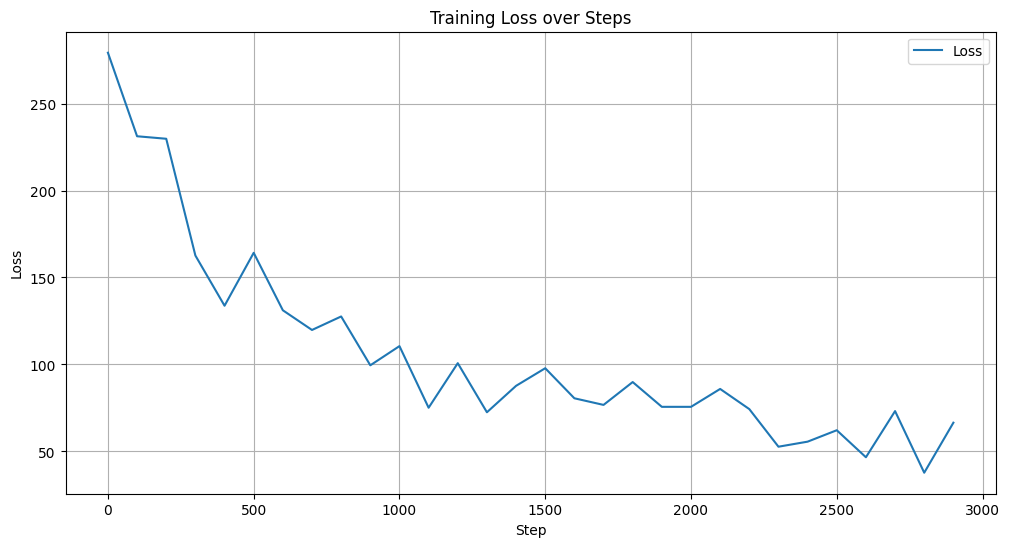

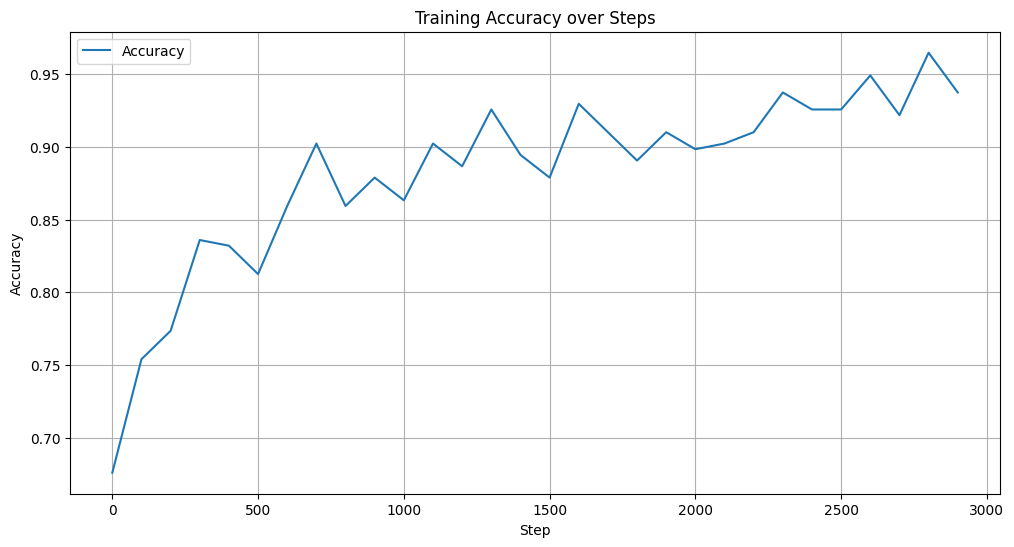

In [13]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Steps')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Обчисліть точність навченої нейромережі
def compute_accuracy(model, test_data):
    test_accuracy = tf.keras.metrics.Mean()
    for batch_x, batch_y in test_data:
        predictions = model(batch_x)
        acc = accuracy(predictions, batch_y)
        test_accuracy.update_state(acc)
    return test_accuracy.result().numpy()
# Тестування моделі на тестових даних
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
final_accuracy = compute_accuracy(neural_net, test_data)

print(f"Test Accuracy: {final_accuracy * 100:.2f}%")

Test Accuracy: 90.21%


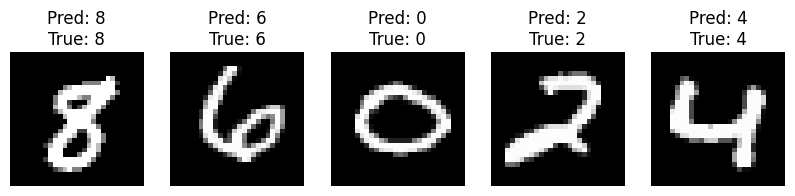

З 5 тестових зображень вгадано 5 зображень.
Точність: 100.00%


In [16]:
# Протестуйте навчену нейромережу на 10 зображеннях.
#З тестової вибірки візьміть 5 випадкових зображень

random_indices = random.sample(range(len(x_test)), 5)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]
#і передайте їх у нейронну мережу.
predictions = neural_net(test_images)
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {tf.argmax(predictions[i]).numpy()}\nTrue: {test_labels[i]}")
    plt.axis('off')
plt.show()


# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
correct_predictions = sum(tf.argmax(predictions, axis=1).numpy() == test_labels)
accuracy = correct_predictions / len(test_labels)
print(f"З 5 тестових зображень вгадано {correct_predictions} зображень.")
print(f"Точність: {accuracy * 100:.2f}%")


